In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load datasets
ratings = pd.read_csv("ratings.dat", sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"])
movies = pd.read_csv("movies.dat", sep="::", engine="python", encoding="ISO-8859-1", names=["MovieID", "Title", "Genres"])

# Merge and process data
data = pd.merge(ratings, movies, on="MovieID")
data["Genres"] = data["Genres"].str.split('|')
data = data.explode("Genres")

# Filter top genres to reduce arms
popular_genres = data["Genres"].value_counts().head(10).index.tolist()
data = data[data["Genres"].isin(popular_genres)]

arms = sorted(data["Genres"].unique())
print(f"Using {len(arms)} arms (genres): {arms}")


Using 10 arms (genres): ['Action', 'Adventure', "Children's", 'Comedy', 'Crime', 'Drama', 'Horror', 'Romance', 'Sci-Fi', 'Thriller']


In [4]:
# Create cached reward pools for each genre
rewards_by_genre = defaultdict(list)
for _, row in data.iterrows():
    rewards_by_genre[row["Genres"]].append(row["Rating"] / 5)  # normalize to [0, 1]

# Convert reward lists to numpy arrays for fast access
sample_pool = {genre: np.array(rewards_by_genre[genre]) for genre in arms}


In [6]:
# Thompson Sampling with optimized sampling
def run_thompson_sampling(n_rounds=100000, B=5):
    np.random.seed(42)
    regret_list = []

    true_means = {genre: np.mean(sample_pool[genre]) for genre in arms}
    optimal_mean = max(true_means.values())

    alpha = {genre: 1 for genre in arms}
    beta = {genre: 1 for genre in arms}
    T = {genre: 0 for genre in arms}
    reward_sums = {genre: 0 for genre in arms}
    regrets = []

    for t in range(len(arms)):
        genre = arms[t]
        reward = sample_pool[genre][np.random.randint(len(sample_pool[genre]))]
        alpha[genre] += reward
        beta[genre] += (1 - reward)
        T[genre] += 1
        reward_sums[genre] += reward
        regrets.append(optimal_mean * (t + 1) - sum(reward_sums.values()))

    for t in range(len(arms), n_rounds):
        sampled_means = {genre: np.random.beta(alpha[genre], beta[genre]) for genre in arms}
        chosen_genre = max(sampled_means, key=sampled_means.get)
        reward = sample_pool[chosen_genre][np.random.randint(len(sample_pool[chosen_genre]))]
        alpha[chosen_genre] += reward
        beta[chosen_genre] += (1 - reward)
        T[chosen_genre] += 1
        reward_sums[chosen_genre] += reward
        regrets.append(optimal_mean * (t + 1) - sum(reward_sums.values()))

    return regrets


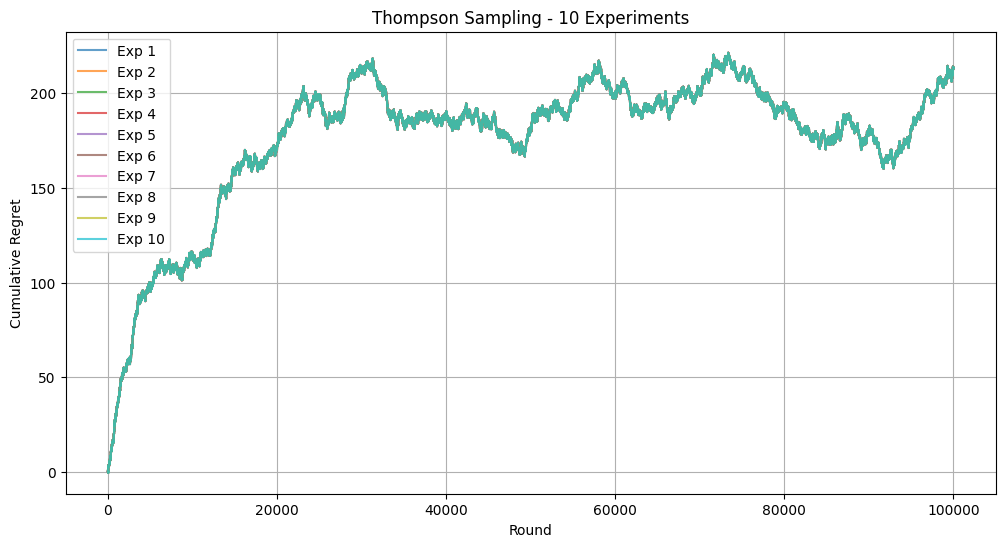

In [7]:
# Run 10 experiments and plot all
all_regrets = []
for i in range(10):
    regrets = run_thompson_sampling()
    all_regrets.append(regrets)

plt.figure(figsize=(12, 6))
for i, regrets in enumerate(all_regrets):
    plt.plot(regrets, label=f"Exp {i+1}", alpha=0.7)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Thompson Sampling - 10 Experiments")
plt.grid(True)
plt.legend()
plt.show()


Running 100 Thompson Sampling experiments in parallel...
Finished in 19.23 seconds.


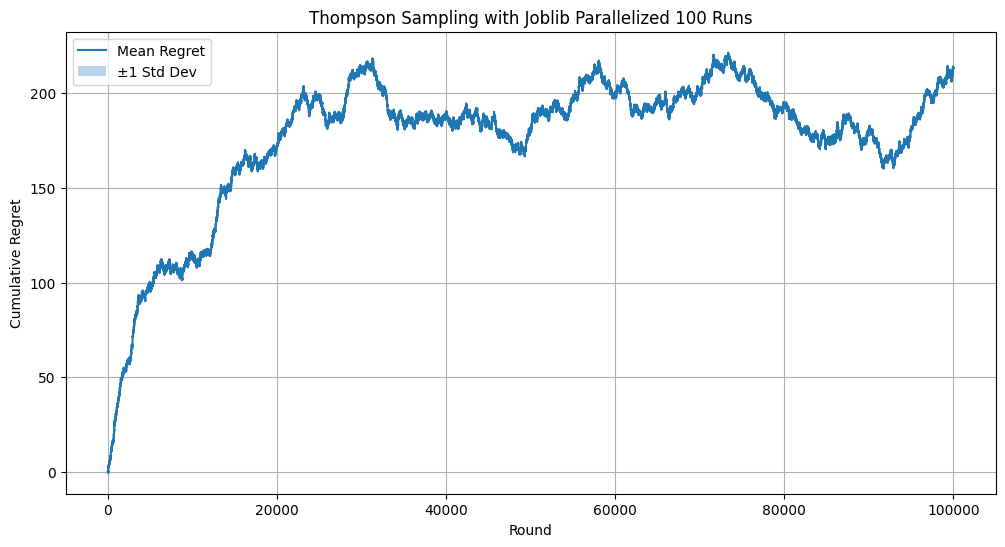

In [8]:
from joblib import Parallel, delayed
import time

# Run Thompson Sampling once
def run_ts_once():
    return run_thompson_sampling(n_rounds=100000)

# Run 100 experiments in parallel using joblib
start = time.time()
print("Running 100 Thompson Sampling experiments in parallel...")

regret_matrix = Parallel(n_jobs=12)(
    delayed(run_ts_once)() for _ in range(100)
)

print("Finished in", round(time.time() - start, 2), "seconds.")

# Compute average and std deviation
regret_matrix = np.array(regret_matrix)
avg_regret = np.mean(regret_matrix, axis=0)
std_regret = np.std(regret_matrix, axis=0)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(avg_regret, label="Mean Regret")
plt.fill_between(range(100000), avg_regret - std_regret, avg_regret + std_regret, alpha=0.3, label="±1 Std Dev")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Thompson Sampling with Joblib Parallelized 100 Runs")
plt.legend()
plt.grid(True)
plt.show()


Finished 100 experiments in 42.96 seconds.


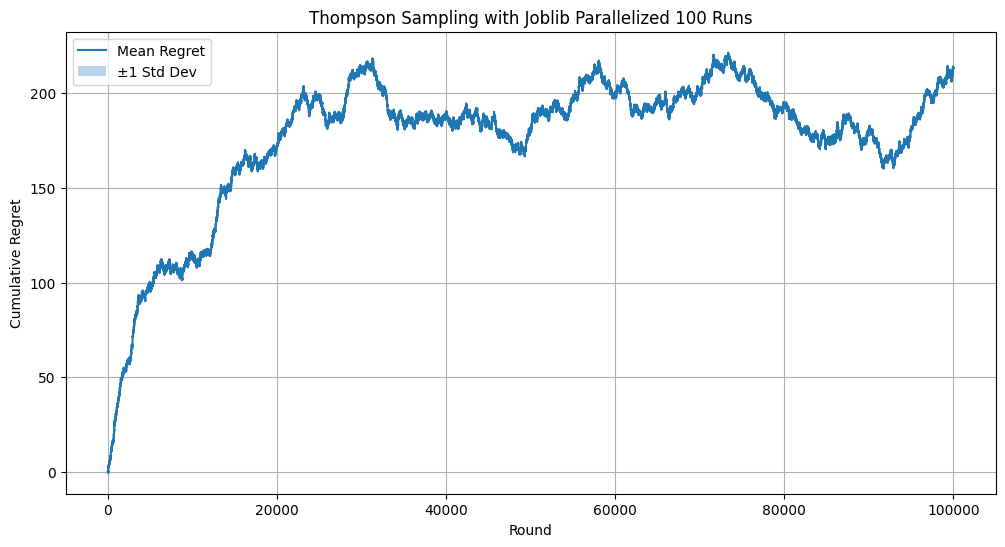

In [10]:
from joblib import Parallel, delayed
import time

# Run 100 experiments in parallel using joblib
def run_ts_once():
    return run_thompson_sampling(n_rounds=100000)

start = time.time()
regret_matrix = Parallel(n_jobs=12)(
    delayed(run_ts_once)() for _ in range(100)
)
print("Finished 100 experiments in", round(time.time() - start, 2), "seconds.")

# Convert to numpy array & compute mean/std
regret_matrix = np.array(regret_matrix)
avg_regret = np.mean(regret_matrix, axis=0)
std_regret = np.std(regret_matrix, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_regret, label="Mean Regret")
plt.fill_between(range(100000), avg_regret - std_regret, avg_regret + std_regret, alpha=0.3, label="±1 Std Dev")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Thompson Sampling with Joblib Parallelized 100 Runs")
plt.legend()
plt.grid(True)
plt.show()


Running 100 Thompson Sampling experiments in parallel...
Finished in 19.22 seconds.


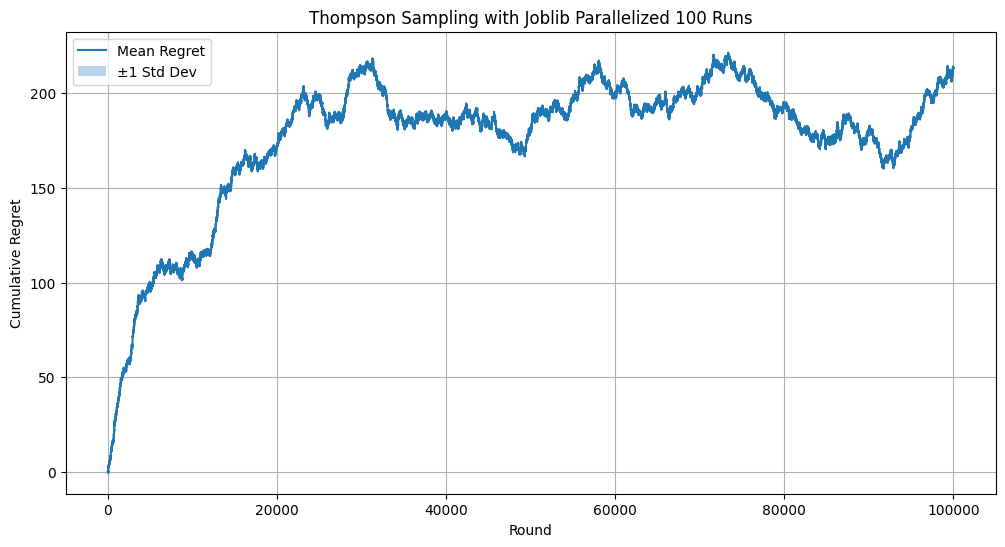

In [12]:
from joblib import Parallel, delayed
import time

# Run Thompson Sampling once
def run_ts_once():
    return run_thompson_sampling(n_rounds=100000)

# Run 100 experiments in parallel using joblib
start = time.time()
print("Running 100 Thompson Sampling experiments in parallel...")

regret_matrix = Parallel(n_jobs=12)(
    delayed(run_ts_once)() for _ in range(100)
)

print("Finished in", round(time.time() - start, 2), "seconds.")

# Compute average and std deviation
regret_matrix = np.array(regret_matrix)
avg_regret = np.mean(regret_matrix, axis=0)
std_regret = np.std(regret_matrix, axis=0)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(avg_regret, label="Mean Regret")
plt.fill_between(range(100000), avg_regret - std_regret, avg_regret + std_regret, alpha=0.3, label="±1 Std Dev")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Thompson Sampling with Joblib Parallelized 100 Runs")
plt.legend()
plt.grid(True)
plt.show()


Running parallel Thompson Sampling for horizon n = 500
Running parallel Thompson Sampling for horizon n = 5000
Running parallel Thompson Sampling for horizon n = 50000
Running parallel Thompson Sampling for horizon n = 500000
Running parallel Thompson Sampling for horizon n = 5000000


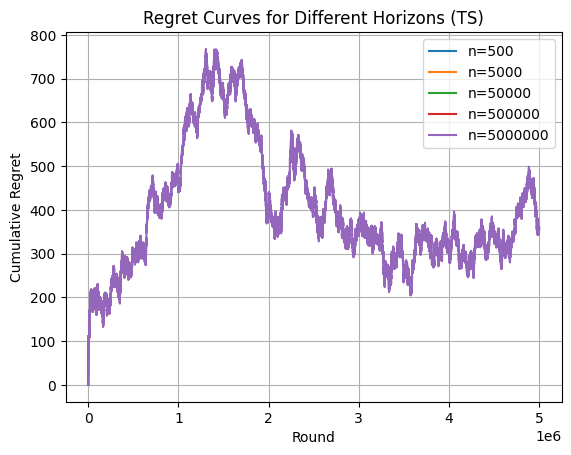

In [13]:
from joblib import Parallel, delayed

horizon_values = [500, 5000, 50000, 500000, 5000000]
horizon_results = {}

for n in horizon_values:
    print(f"Running parallel Thompson Sampling for horizon n = {n}")
    regrets_matrix = Parallel(n_jobs=10)(
        delayed(run_thompson_sampling)(n_rounds=n) for _ in range(20)
    )
    avg_regret = np.mean(regrets_matrix, axis=0)
    horizon_results[n] = avg_regret

# Plot comparisons
for n in horizon_values:
    plt.plot(horizon_results[n], label=f"n={n}")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Regret Curves for Different Horizons (TS)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def run_etc(n_rounds=100000, m=1000):
    np.random.seed(42)
    regrets = []

    true_means = {genre: np.mean(sample_pool[genre]) for genre in arms}
    optimal_mean = max(true_means.values())

    T = {genre: 0 for genre in arms}
    reward_sums = {genre: 0 for genre in arms}

    # Exploration phase
    for i in range(m * len(arms)):
        genre = arms[i % len(arms)]
        reward = sample_pool[genre][np.random.randint(len(sample_pool[genre]))]
        T[genre] += 1
        reward_sums[genre] += reward
        regrets.append(optimal_mean * (i + 1) - sum(reward_sums.values()))

    # Estimate means
    estimated_means = {genre: reward_sums[genre] / T[genre] for genre in arms}
    best_genre = max(estimated_means, key=estimated_means.get)

    # Exploitation phase
    for i in range(m * len(arms), n_rounds):
        reward = sample_pool[best_genre][np.random.randint(len(sample_pool[best_genre]))]
        T[best_genre] += 1
        reward_sums[best_genre] += reward
        regrets.append(optimal_mean * (i + 1) - sum(reward_sums.values()))

    return regrets


In [15]:
import numpy as np

def run_ucb(n_rounds=100000, c=2):
    np.random.seed(42)
    regrets = []

    true_means = {genre: np.mean(sample_pool[genre]) for genre in arms}
    optimal_mean = max(true_means.values())

    T = {genre: 0 for genre in arms}
    reward_sums = {genre: 0 for genre in arms}
    ucb_values = {genre: 0 for genre in arms}

    # Initial pulls
    for t in range(len(arms)):
        genre = arms[t]
        reward = sample_pool[genre][np.random.randint(len(sample_pool[genre]))]
        T[genre] += 1
        reward_sums[genre] += reward
        regrets.append(optimal_mean * (t + 1) - sum(reward_sums.values()))

    # Main loop
    for t in range(len(arms), n_rounds):
        for genre in arms:
            if T[genre] > 0:
                mean = reward_sums[genre] / T[genre]
                confidence = c * np.sqrt(np.log(t + 1) / T[genre])
                ucb_values[genre] = mean + confidence
            else:
                ucb_values[genre] = float('inf')

        chosen_genre = max(ucb_values, key=ucb_values.get)
        reward = sample_pool[chosen_genre][np.random.randint(len(sample_pool[chosen_genre]))]
        T[chosen_genre] += 1
        reward_sums[chosen_genre] += reward
        regrets.append(optimal_mean * (t + 1) - sum(reward_sums.values()))

    return regrets


Running all 3 algorithms with 10 parallel runs each...
All algorithm comparisons completed in 77.05 seconds.


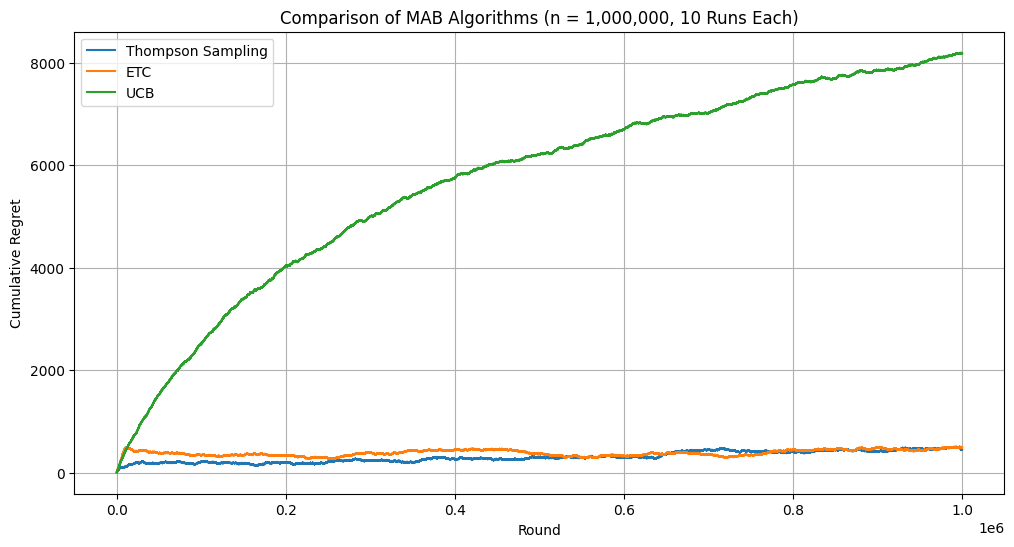

In [16]:
from joblib import Parallel, delayed
import time

# Final horizon
n_final = 1000000

# Parallel wrappers
def run_ts_final():
    return run_thompson_sampling(n_rounds=n_final)

def run_etc_final():
    return run_etc(n_rounds=n_final)

def run_ucb_final():
    return run_ucb(n_rounds=n_final)

start = time.time()
print("Running all 3 algorithms with 10 parallel runs each...")

ts_regret = np.mean(Parallel(n_jobs=12)(delayed(run_ts_final)() for _ in range(10)), axis=0)
etc_regret = np.mean(Parallel(n_jobs=12)(delayed(run_etc_final)() for _ in range(10)), axis=0)
ucb_regret = np.mean(Parallel(n_jobs=12)(delayed(run_ucb_final)() for _ in range(10)), axis=0)

print("All algorithm comparisons completed in", round(time.time() - start, 2), "seconds.")

# Plot
plt.figure(figsize=(12,6))
plt.plot(ts_regret, label="Thompson Sampling")
plt.plot(etc_regret, label="ETC")
plt.plot(ucb_regret, label="UCB")
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Comparison of MAB Algorithms (n = 1,000,000, 10 Runs Each)")
plt.legend()
plt.grid(True)
plt.show()
